In [19]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
# construct the argument parser and parse the arguments

class Args:
    image = 'lib_test_small/Erwan.jpg'
    embeddings = 'output/embeddings.pickle'
    detector = 'face_detection_model/'
    embedding_model = 'openface.nn4.small2.v1.t7'
    confidence = 0.8
    le = 'output/le.pickle'
    recognizer = 'output/recognizer.pickle'
    
args = Args()
    

In [20]:
# load our serialized face detector from disk
print("[INFO] loading face detector...")
protoPath = os.path.sep.join([args.detector, "deploy.prototxt.txt"])
modelPath = os.path.sep.join([args.detector,
	"res10_300x300_ssd_iter_140000.caffemodel"])
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch(args.embedding_model)
# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(args.recognizer, "rb").read())
le = pickle.loads(open(args.le, "rb").read())

[INFO] loading face detector...
[INFO] loading face recognizer...


In [ ]:
# load the image, resize it to have a width of 600 pixels (while
# maintaining the aspect ratio), and then grab the image dimensions
image = cv2.imread(args.image)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300, 300)), 1.0, (300, 300),
    (104.0, 177.0, 123.0), swapRB=False, crop=False)
# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the
    # prediction
    confidence = detections[0, 0, i, 2]
    # filter out weak detections
    if confidence > args.confidence:
        # compute the (x, y)-coordinates of the bounding box for the
        # face
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # extract the face ROI
        face = image[startY:endY, startX:endX]
#         cv2.imshow("Alexandre", face)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        (fH, fW) = face.shape[:2]
        # ensure the face width and height are sufficiently large
        if fW < 20 or fH < 20:
            continue
        # construct a blob for the face ROI, then pass the blob
        # through our face embedding model to obtain the 128-d
        # quantification of the face
        faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),(0, 0, 0), swapRB=True, crop=False)
        embedder.setInput(faceBlob)
        vec = embedder.forward()
        # perform classification to recognize the face
        preds = recognizer.predict_proba(vec)[0]
        j = np.argmax(preds)
        proba = preds[j]
        name = le.classes_[j]
        # draw the bounding box of the face along with the associated
        # probability
        text = "{}: {:.2f}%".format(name, proba * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.rectangle(image, (startX, startY), (endX, endY),
            (0, 0, 255), 2)
        cv2.putText(image, text, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1.4)
# show the output image
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [21]:
from sklearn.metrics import confusion_matrix
# import os
# import cv2
# import numpy as np
import matplotlib.pyplot as plt

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [23]:
def detect_face(image, idx):
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    # construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(
        cv2.resize(image, (300, 300)), 1.0, (300, 300),
        (104.0, 177.0, 123.0), swapRB=False, crop=False)
    # apply OpenCV's deep learning-based face detector to localize
    # faces in the input image
    detector.setInput(imageBlob)
    detections = detector.forward()

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        confidence = detections[0, 0, i, 2]
        # filter out weak detections
        if confidence > args.confidence:
            # compute the (x, y)-coordinates of the bounding box for the
            # face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # extract the face ROI
            face = image[startY:endY, startX:endX]
    #         cv2.imshow("Alexandre", face)
    #         cv2.waitKey(0)
    #         cv2.destroyAllWindows()
            (fH, fW) = face.shape[:2]
            # ensure the face width and height are sufficiently large
            if fW < 20 or fH < 20:
                continue
            # construct a blob for the face ROI, then pass the blob
            # through our face embedding model to obtain the 128-d
            # quantification of the face
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),(0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()
            # perform classification to recognize the face
            preds = recognizer.predict_proba(vec)[0]
            j = np.argmax(preds)
            proba = preds[j]
            name = le.classes_[j]
            return name

Actual 	:  Albena (1).jpg
Predic 	:  Albena


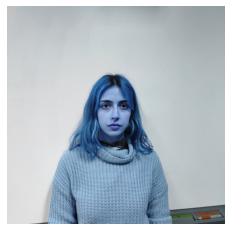

Actual 	:  Albena (2).jpg
Predic 	:  Albena


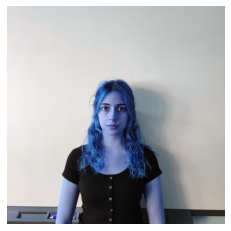

Actual 	:  Albena (3).jpg
Predic 	:  Albena


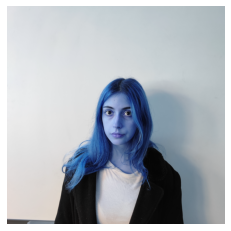

Actual 	:  Albena (4).jpg
Predic 	:  Unknown


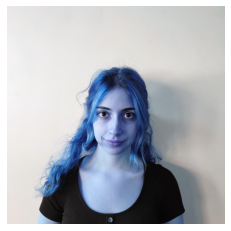

Actual 	:  Albena (5).jpg
Predic 	:  Albena


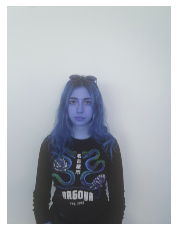

Actual 	:  AlexandreF (1).jpg
Predic 	:  AlexandreF


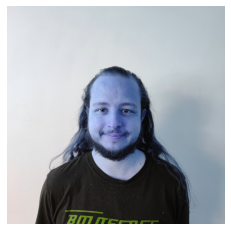

Actual 	:  AlexandreF (2).jpg
Predic 	:  AlexandreF


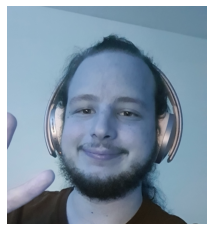

Actual 	:  AlexandreF (3).jpg
Predic 	:  Unknown


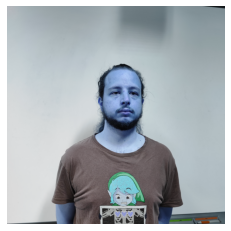

Actual 	:  AlexandreF (4).jpg
Predic 	:  AlexandreF


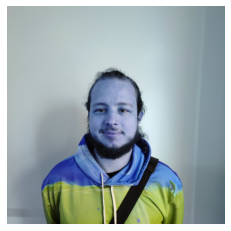

Actual 	:  AlexandreF (5).jpg
Predic 	:  AlexandreF


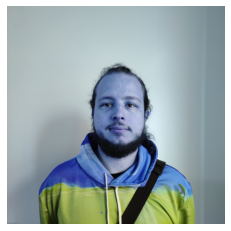

Actual 	:  Dorian (1).jpg
Predic 	:  Gauthier


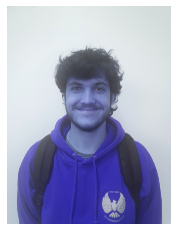

Actual 	:  Dorian (2).jpg
Predic 	:  Dorian


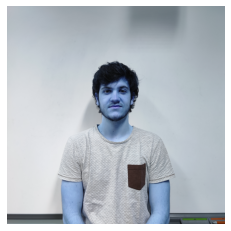

Actual 	:  Dorian (3).jpg
Predic 	:  Dorian


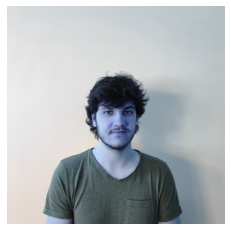

Actual 	:  Dorian (4).jpg
Predic 	:  Dorian


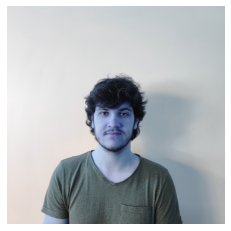

Actual 	:  Dorian (5).jpg
Predic 	:  Albena


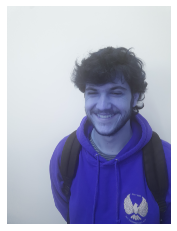

Actual 	:  Erwan (1).jpg
Predic 	:  Erwan


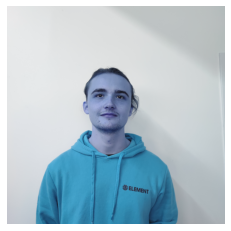

Actual 	:  Erwan (2).jpg
Predic 	:  Erwan


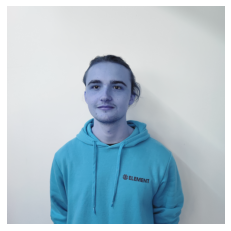

Actual 	:  Erwan (3).jpg
Predic 	:  Erwan


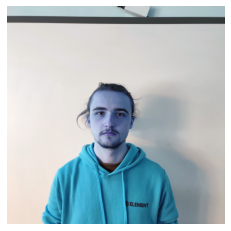

Actual 	:  Erwan (4).jpg
Predic 	:  Erwan


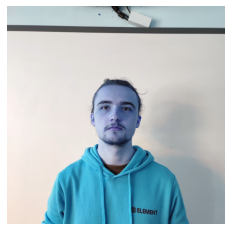

Actual 	:  Erwan (5).jpg
Predic 	:  Erwan


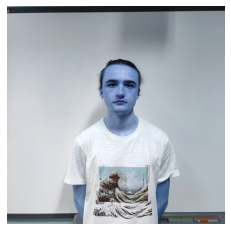

Actual 	:  Gauthier (1).jpg
Predic 	:  Gauthier


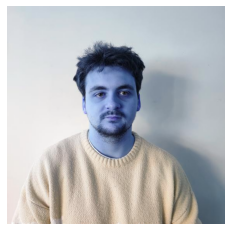

Actual 	:  Gauthier (2).jpg
Predic 	:  Gauthier


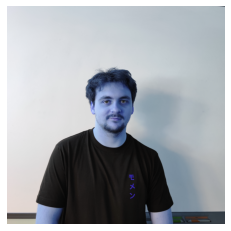

Actual 	:  Gauthier (3).jpg
Predic 	:  Gauthier


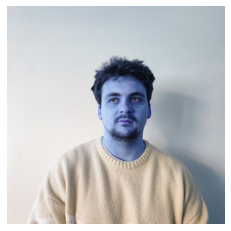

Actual 	:  Gauthier (4).jpg
Predic 	:  Gauthier


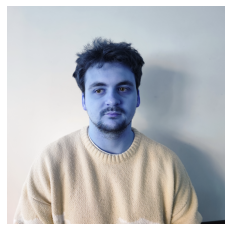

Actual 	:  Gauthier (5).jpg
Predic 	:  Gauthier


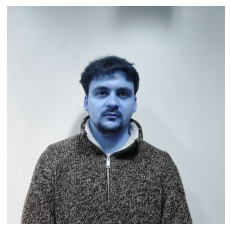

Actual 	:  Unknown (1).jpg
Predic 	:  Unknown


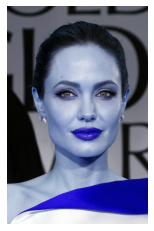

Actual 	:  Unknown (2).jpg
Predic 	:  Unknown


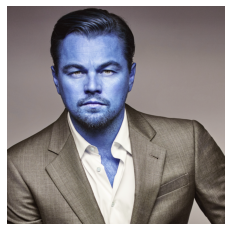

In [29]:
test_folder = "lib_test_small/"
actual_names = []
predicted_names = []
for filename in os.listdir(test_folder):
    if filename.find(".jpg") > -1:
        path = os.path.join(test_folder, filename)
        
        img = cv2.imread(path)
        name = detect_face(img, 0)

        #idx, confidence = model.predict(img)
        
        actual_names.append(filename[:-8]) #get label from filename (remove 9 last char)
        predicted_names.append(name)
        
        print("Actual \t: ", filename)
        print("Predic \t: ", name)

        plt.figure()
        plt.imshow(img, cmap="gray")
        plt.axis(False)
        plt.show()

In [30]:
labels = np.unique(actual_names)

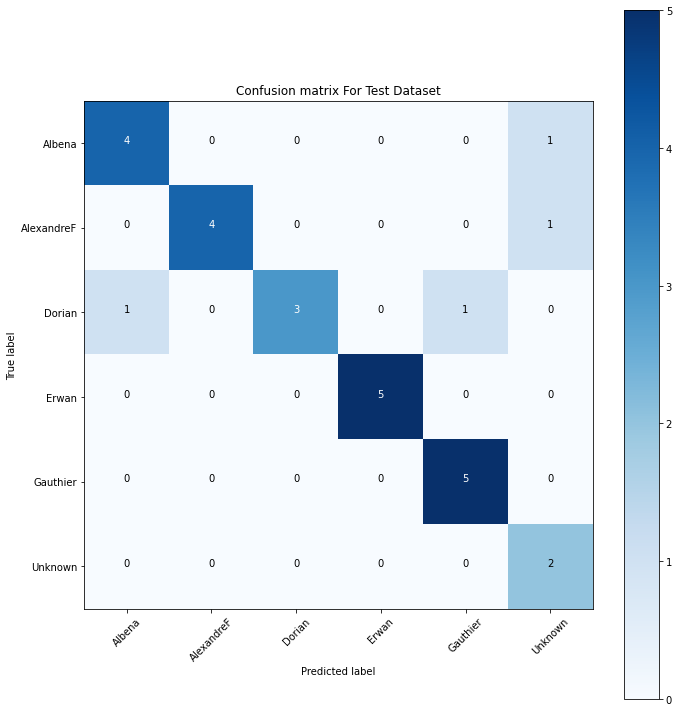

In [31]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(actual_names, predicted_names)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix For Test Dataset')

In [32]:
from sklearn.metrics import classification_report

In [33]:
print("== Classification Report for Test Dataset ==\n")
print(classification_report(actual_names, 
                            predicted_names, 
                            target_names=labels))

== Classification Report for Test Dataset ==

              precision    recall  f1-score   support

      Albena       0.80      0.80      0.80         5
  AlexandreF       1.00      0.80      0.89         5
      Dorian       1.00      0.60      0.75         5
       Erwan       1.00      1.00      1.00         5
    Gauthier       0.83      1.00      0.91         5
     Unknown       0.50      1.00      0.67         2

    accuracy                           0.85        27
   macro avg       0.86      0.87      0.84        27
weighted avg       0.90      0.85      0.85        27

